In [2]:
import numpy as np
import time
import math
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook

[['a' 'b' 'c']
 ['d' 'e' 'f']
 ['g' 'h' 'i']
 ['j' 'k' 'l']]
[{'a': 0, 'd': 1, 'g': 2, 'j': 3}, {'b': 0, 'e': 1, 'h': 2, 'k': 3}, {'c': 0, 'f': 1, 'i': 2, 'l': 3}]


<IPython.core.display.Javascript object>


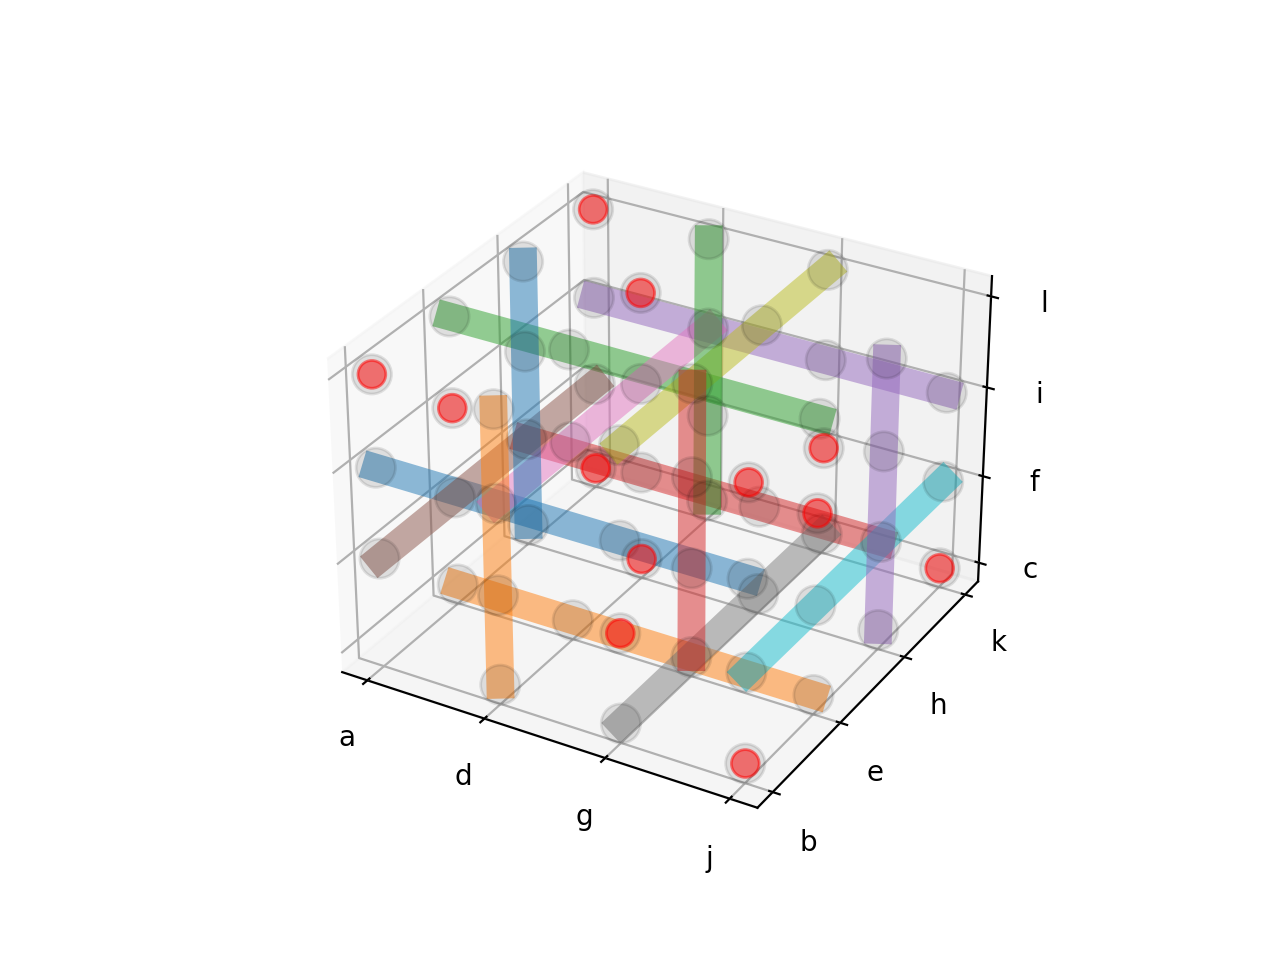

['bi', 'ec', 'el', 'hf', 'ki', 'af', 'di', 'gc', 'gl', 'jf', 'ah', 'db', 'dk', 'ge', 'jh']
total # of unwanted terms=12
unwanted terms:
[0 0 3] abl
[0 1 2] aei
[0 3 0] akc
[0 3 3] akl
[1 2 0] dhc
[1 2 3] dhl
[2 0 1] gbf
[2 3 1] gkf
[3 0 0] jbc
[3 0 3] jbl
[3 1 2] jei
[3 3 0] jkc


In [151]:
'''
based on the paper "On Practical Algorithms for Accelerated Matrix Multiplication" (Laderman, Pan, Sha)
'''
N,A=4,3
prods=np.array([chr(ord('a')+i) for i in range(N*A)]).reshape((N,A))#['abc','pqr','uvw','xyz']#['abc','uvw','xyz']#
print(prods)
groups=np.transpose(prods)
coords=list(map(lambda s:{s[i]:i for i in range(len(s))},groups))
print(coords)
def toltrs(s):
    axes=[list(g) for g in groups]
    for c in s:
        for ax in range(A):
            if c in groups[ax]:
                axes[ax]=[c]
                break
    return axes
def toaxes(ltrsets):
    out=[[]]*A
    for ax in range(A):
        out[ax]=[0]*N
        for ltr in ltrsets[ax]:
            out[ax][coords[ax][ltr]]=1
    return np.array(out)
def oprod(T):
    out=T[0]
    for i in range(1,len(T)):
        out=np.multiply.outer(out,T[i])
    return out
def ID(N,d):
    out=np.zeros((N,)*d,dtype=int)
    for i in range(N):
        out[(i,)*A]=1
    return out
fig=plt.figure()
ax=fig.add_subplot(projection='3d')
ax.set_xticks(range(N))
ax.set_yticks(range(N))
ax.set_zticks(range(N))
ax.set_xticklabels(groups[0])
ax.set_yticklabels(groups[1])
ax.set_zticklabels(groups[2])
target=oprod([[1]*N]*A)-ID(N,A)
ax.scatter(*np.where(target>0),c='black',s=200,alpha=0.1)
idxtype={prods[n][a]:(a+n)%A for n in range(N) for a in range(A)}
pcs=[]
for a in range(A):
    axes=list(groups[:])
    del axes[a]
    for v0 in axes[0]:
        for v1 in axes[1]:
            if idxtype[v0]==idxtype[v1]:
                pcs.append(v0+v1)
print(pcs)
ret=target
for pc in pcs:
    t=oprod(toaxes(toltrs(pc)))
    ret-=t
    ax.plot(*np.where(t),alpha=0.5,linewidth=10)
for i in range(N):
    assert ret[(i,)*A]==0, 'removed target term'
ret=np.maximum(ret,0)
ax.scatter(*np.where(ret>0),c='red',s=100,alpha=0.5)
print('total # of unwanted terms='+str(np.sum(ret)))
print('unwanted terms:')
for pt in np.transpose(np.where(ret>0)):
    print(str(pt)+' '+''.join([prods[pt[i]][i] for i in range(A)]))

In [13]:
def tot_terms(N,A,combos):
    #find sets of coords of unwanted terms
    idxtype=np.array([[(r+c)%A for c in range(A)] for r in range(N)])
    #0->ij, 1->jk, 2->ki
    idxgroup=[]
    for i in range(A):
        idxgroup.append((i,(i+1)%A))
    special_terms=[]
    for term in np.transpose(np.where(np.zeros((N,)*3)==0)):
        if len(set([idxtype[term[i]][i] for i in range(A)]))==A:
            special_terms.append(term)
    print(special_terms)

    def terms(S,R):
        S,R=map(lambda x:np.array(x).astype(int),(S,R))
        assert S.shape==(N,A) and R.shape==(N,A), 'incorrect shapes of S, R'
        for r in range(N):
            assert np.prod(S[r])==1, 'product(S['+str(r)+'])='+str(np.prod(S[r]))+'!=1'
        print('S='+str(S))
        print('R='+str(R))
        out={}
        for term in special_terms:
            coeff=1
            for i in range(A):
                coeff*=S[term[i]][i]
            idxsig=[]
            for i in range(A):
                group=[R[term[i]][j] for j in idxgroup[idxtype[term[i]][i]]]
                idxsig.append(tuple(group))
            out[(tuple(term),tuple(idxsig))]=coeff
        return out

    def add_terms(T0,T1):
        terms=set([*set(T0.keys()),*set(T1.keys())])
        out={}
        for t in terms:
            coeff=(T0[t] if t in T0 else 0)+(T1[t] if t in T1 else 0)
            if coeff!=0:
                out[t]=coeff
        return out

    tT={}
    for combo in combos:
        tT=add_terms(tT,terms(*combo))
    return tT

#Pan's solution for 3-way trilinear aggregation for 2x2 block matrices having nxn matrices as elements
coeffss=[]
for i in range(4):
    S=np.ones((N,A))
    if i>0:
        S[i-1][0]=S[i-1][2]=-1
    coeffss.append(S)
sigs=[np.zeros((N,A)),[[0,0,1],[0,1,0],[1,0,0]],[[0,1,0],[1,0,0],[0,0,1]],[[1,0,0],[0,0,1],[0,1,0]]]
tT=tot_terms(3,3,[*[(coeffss[i],sigs[i]) for i in range(4)],*[(coeffss[i],1-np.array(sigs[i])) for i in range(4)]])
keys=sorted(list(tT.keys()))
for k in keys:
    print(('!!!' if len(set(k[0]))>1 else '')+str(k).replace(' ','')+': '+str(tT[k]))
print('tot # keys='+str(len(tT)))

[array([0, 0, 0]), array([0, 1, 2]), array([1, 1, 1]), array([1, 2, 0]), array([2, 0, 1]), array([2, 2, 2])]
S=[[1 1 1]
 [1 1 1]
 [1 1 1]]
R=[[0 0 0]
 [0 0 0]
 [0 0 0]]
S=[[-1  1 -1]
 [ 1  1  1]
 [ 1  1  1]]
R=[[0 0 1]
 [0 1 0]
 [1 0 0]]
S=[[ 1  1  1]
 [-1  1 -1]
 [ 1  1  1]]
R=[[0 1 0]
 [1 0 0]
 [0 0 1]]
S=[[ 1  1  1]
 [ 1  1  1]
 [-1  1 -1]]
R=[[1 0 0]
 [0 0 1]
 [0 1 0]]
S=[[1 1 1]
 [1 1 1]
 [1 1 1]]
R=[[1 1 1]
 [1 1 1]
 [1 1 1]]
S=[[-1  1 -1]
 [ 1  1  1]
 [ 1  1  1]]
R=[[1 1 0]
 [1 0 1]
 [0 1 1]]
S=[[ 1  1  1]
 [-1  1 -1]
 [ 1  1  1]]
R=[[1 0 1]
 [0 1 1]
 [1 1 0]]
S=[[ 1  1  1]
 [ 1  1  1]
 [-1  1 -1]]
R=[[0 1 1]
 [1 1 0]
 [1 0 1]]
((0,0,0),((0,0),(0,0),(0,0))): 1
((0,0,0),((0,0),(0,1),(1,0))): 1
((0,0,0),((0,1),(1,0),(0,0))): 1
((0,0,0),((0,1),(1,1),(1,0))): 1
((0,0,0),((1,0),(0,0),(0,1))): 1
((0,0,0),((1,0),(0,1),(1,1))): 1
((0,0,0),((1,1),(1,0),(0,1))): 1
((0,0,0),((1,1),(1,1),(1,1))): 1
((1,1,1),((0,0),(0,0),(0,0))): 1
((1,1,1),((0,0),(0,1),(1,0))): 1
((1,1,1),((0,1),(1,0),(0,0)